In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
# import tushare as ts
# import QUANTAXIS as QA
import talib as ta
import datetime, time
from dateutil.relativedelta import *
from pandas.tseries.offsets import *
from tqdm import tqdm_notebook

In [5]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.style.use('ggplot')

crsp fiscal resample

In [12]:
def rolling_forward(df, roll_per, min_per=1):
    return ((df[::-1]).rolling(roll_per, min_per).apply(np.prod, raw=True))[::-1]

def calc_exf(df):
    ret = df.ret_p1
    dret = df.dret_p1
    exf = df.mv - df.mv.shift(1) * df.retx_p1
    exf_to_mv = exf / df.mv.shift(1)
    
    car1 = rolling_forward(ret, 1) - rolling_forward(dret, 1)
    car3 = rolling_forward(ret, 3) - rolling_forward(dret, 3)
    car5 = rolling_forward(ret, 5) - rolling_forward(dret, 5)
    
    wr5 = rolling_forward(ret, 5) - rolling_forward(dret, 5)
    
    ret_n1 = rolling_forward(ret, 1)
    ret_n2 = rolling_forward(ret, 2)
    ret_n3 = rolling_forward(ret, 3)
    ret_n4 = rolling_forward(ret, 4)
    ret_n5 = rolling_forward(ret, 5)
    ret_n6 = rolling_forward(ret, 6)
    ret_n7 = rolling_forward(ret, 7)
    ret_n8 = rolling_forward(ret, 8)
    
    res = pd.DataFrame({
        'date':df.date,
        'mv':df.mv,
#         'mv_adj':df.mv_adj,
#         'ret_p1':df.ret_p1,
        'retx_p1':df.retx_p1,
#         'dret_p1':df.dret_p1,
        'exf':exf,
        'exf_to_mv':exf_to_mv,
        'car1':car1.shift(-1),
        'car3':car3.shift(-1),
        'car5':car5.shift(-1),
        'wr5':wr5.shift(-1),
        'ret_n1':ret_n1.shift(-1),
        'ret_n2':ret_n2.shift(-1),
        'ret_n3':ret_n3.shift(-1),
        'ret_n4':ret_n4.shift(-1),
        'ret_n5':ret_n5.shift(-1),
        'ret_n6':ret_n6.shift(-1),
        'ret_n7':ret_n7.shift(-1),
        'ret_n8':ret_n8.shift(-1)
    })
    return res

In [13]:
crsp_fa = pd.read_csv('data/crsp_fa.zip',
                     parse_dates=['date'], infer_datetime_format=True)

查看firm-years数量

ps:因为流通股数的单位默认是1000, 故mv_adj只需要大于50000即可

In [7]:
crsp_fa[crsp_fa.mv_adj >= 5e+4].shape[0]

145087

In [14]:
crsp_fa = crsp_fa[crsp_fa.mv_adj >= 5e+4]

In [15]:
tic = time.perf_counter()
crsp_fa = crsp_fa.set_index('permno').groupby('permno').apply(calc_exf)
toc = time.perf_counter()
print(toc-tic)

262.6509182



exf_to_mv : $EXF_{t}/MV_{t-1}$

ret_n1 : 接下来1年的return


In [17]:
from scipy.stats import mstats

In [20]:
crsp_fa.head()

,date,mv,retx_p1,exf,exf_to_mv,car1,car3,car5,wr5,ret_n1,ret_n2,ret_n3,ret_n4,ret_n5,ret_n6,ret_n7,ret_n8
permno,,,,,,,,,,,,,,,,,
10002,1993-12-31,38612.125,1.430557,NaN,NaN,0.111624,-0.337573,0.341395,0.341395,1.039473,1.135239,1.085200,2.130205,2.027591,1.663451,1.310096,1.466758
10002,1994-12-31,39361.875,1.019418,-0.008577,-2.221426e-07,-0.281362,0.121447,-0.897720,-0.897720,1.092129,1.043990,2.049311,1.950594,1.600282,1.260346,1.411059,1.653241
10002,1995-12-31,42028.000,1.066668,41.937460,1.065433e-03,-0.160509,0.462912,-0.522323,-0.522323,0.955922,1.876438,1.786048,1.465287,1.154027,1.292026,1.513779,2.259641
10002,1996-12-31,39026.000,0.928571,-0.001807,-4.298500e-08,0.705720,-0.096200,-0.527141,-0.527141,1.962960,1.868403,1.532852,1.207239,1.351602,1.583579,2.363833,3.730554
10002,1997-12-31,104027.000,1.884614,30478.045526,7.809677e-01,0.009172,-0.579293,-0.533391,-0.533391,0.951829,0.780888,0.615009,0.688553,0.806730,1.204218,1.900473,1.593407


In [57]:
crsp_fa1 = crsp_fa.copy()
crsp_fa1.exf_to_mv = mstats.winsorize(crsp_fa1.exf_to_mv, limits=[0.05, 0.12])
per1 = np.linspace(0,1,11).tolist()
bins = crsp_fa1.describe(percentiles=per1).exf_to_mv.iloc[4:-1].tolist()
bins

[-0.10397077600215242,
 -0.03519540621592579,
 -0.0022545344357224693,
 8.309303863174495e-07,
 0.002531733088195513,
 0.008262611193127871,
 0.020358548741621713,
 0.05587395856532472,
 0.1997928966279134,
 2.1235067912136034,
 2.1235067912136034]

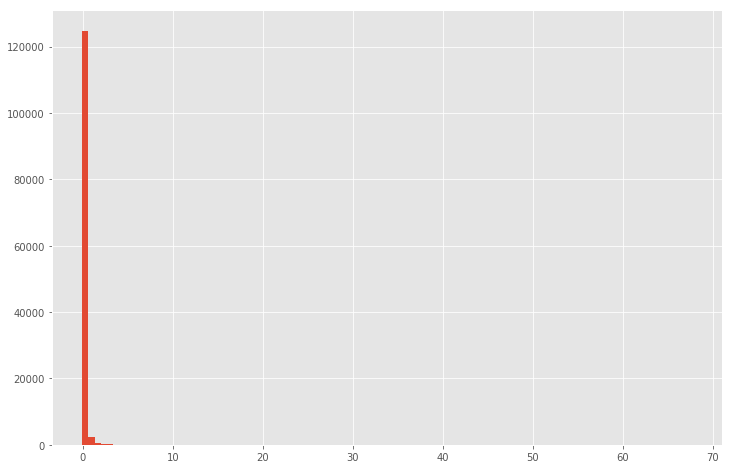

In [52]:
plt.hist(crsp_fa1.exf_to_mv.dropna().tolist(), bins=100);

In [40]:
bins

[-0.10397077600215242,
 -0.04366754136841066,
 -0.006389987387294394,
 -1.412108657001018e-07,
 0.0008299511445806443,
 0.004495931162928125,
 0.010921638332790423,
 0.02404317724271744,
 0.060945963241019176,
 0.185738320062671,
 67.59181503895059]

In [41]:
crsp_fa1.describe(percentiles=per1)

,mv,retx_p1,exf,exf_to_mv,car1,car3,car5,wr5,ret_n1,ret_n2,ret_n3,ret_n4,ret_n5,ret_n6,ret_n7,ret_n8
count,1.450870e+05,145087.000000,1.281630e+05,1.281630e+05,128163.000000,128163.000000,128163.000000,128163.000000,128163.000000,128163.000000,128163.000000,128163.000000,128163.000000,128163.000000,128163.000000,128163.000000
mean,1.642095e+06,1.194604,3.333144e+04,7.281737e-02,0.066627,0.170178,0.262269,0.262269,1.205817,1.404431,1.590537,1.774041,1.968456,2.152546,2.335339,2.515142
std,9.529594e+06,0.922529,1.063562e+06,4.967472e-01,0.852989,1.647565,2.619670,2.619670,0.888442,1.304867,1.718634,2.104589,2.744702,3.453770,3.957961,4.565502
min,1.010500e+04,0.009009,-7.296442e+07,-1.039708e-01,-1.648215,-2.691581,-5.699275,-5.699275,0.009009,0.000527,0.000456,0.000919,0.000678,0.001084,0.001084,0.000814
0%,1.010500e+04,0.009009,-7.296442e+07,-1.039708e-01,-1.648215,-2.691581,-5.699275,-5.699275,0.009009,0.000527,0.000456,0.000919,0.000678,0.001084,0.001084,0.000814
10%,4.179450e+04,0.617373,-1.838776e+04,-4.366754e-02,-0.461194,-0.844386,-1.190811,-1.190811,0.630390,0.554544,0.517955,0.491807,0.477532,0.469493,0.461130,0.455856
20%,6.164198e+04,0.786942,-1.287907e+03,-6.389987e-03,-0.299817,-0.575009,-0.803561,-0.803561,0.807923,0.773678,0.759591,0.746720,0.739822,0.737654,0.733695,0.731069
30.0%,8.846250e+04,0.899578,-1.105937e-02,-1.412109e-07,-0.187452,-0.384441,-0.530107,-0.530107,0.927728,0.940180,0.954567,0.957746,0.962686,0.969377,0.974039,0.977020
40%,1.296732e+05,0.987341,1.237694e+02,8.299511e-04,-0.100718,-0.225584,-0.307666,-0.307666,1.021398,1.071272,1.117287,1.147656,1.175513,1.196721,1.209893,1.220711
50%,1.950075e+05,1.061947,8.700154e+02,4.495931e-03,-0.022573,-0.073122,-0.110765,-0.110765,1.104696,1.198912,1.277751,1.342657,1.403025,1.453572,1.488887,1.517928


In [44]:
per1 = np.linspace(0,1,11).tolist()
bins = crsp_fa1.describe(percentiles=per1).exf_to_mv.iloc[4:-1].tolist()
bins = [bins[0]-1] + bins[1:]
# bins = bins[:-1] + [bins[-1]-1]
crsp_fa1.groupby(pd.cut(crsp_fa1.exf_to_mv,bins, right=True)).mean().drop(['mv', 'retx_p1', 'exf'], axis=1)

,exf_to_mv,car1,car3,car5,wr5,ret_n1,ret_n2,ret_n3,ret_n4,ret_n5,ret_n6,ret_n7,ret_n8
exf_to_mv,,,,,,,,,,,,,
"(-1.104, -0.0437]",-0.088080,0.144545,0.363042,0.558829,0.558829,1.283081,1.512264,1.768227,2.008501,2.224214,2.436819,2.616834,2.811783
"(-0.0437, -0.00639]",-0.020932,0.051137,0.159195,0.253375,0.253375,1.186602,1.351787,1.529133,1.693575,1.877880,2.060574,2.246527,2.371319
"(-0.00639, -1.41e-07]",-0.001351,0.051333,0.149560,0.241607,0.241607,1.217153,1.422320,1.624187,1.841661,2.077819,2.279476,2.492942,2.691350
"(-1.41e-07, 0.00083]",0.000153,0.055527,0.154404,0.264503,0.264503,1.234069,1.460604,1.675533,1.927093,2.192040,2.432775,2.685826,2.962236
"(0.00083, 0.0045]",0.002508,0.069921,0.162226,0.261593,0.261593,1.229314,1.434728,1.614541,1.799581,2.026096,2.217347,2.427173,2.618346
"(0.0045, 0.0109]",0.007398,0.066165,0.150570,0.239824,0.239824,1.216415,1.411707,1.574385,1.751002,1.947903,2.111818,2.270896,2.432522
"(0.0109, 0.024]",0.016600,0.050675,0.164456,0.250523,0.250523,1.191599,1.391491,1.565506,1.728304,1.905416,2.054344,2.200870,2.371584
"(0.024, 0.0609]",0.038750,0.058577,0.153152,0.193398,0.193398,1.192051,1.388212,1.544158,1.688588,1.823631,1.982459,2.110229,2.252196
"(0.0609, 0.186]",0.110957,0.025925,0.084650,0.126351,0.126351,1.163988,1.329445,1.490460,1.635117,1.792502,1.918098,2.081315,2.260494


In [25]:
per1 = np.linspace(0,1,11).tolist()
bins = crsp_fa.describe(percentiles=per1).exf_to_mv.iloc[4:-1].tolist()
bins = [bins[0]-1] + bins[1:]
# bins = bins[:-1] + [bins[-1]-1]
crsp_fa.groupby(pd.cut(crsp_fa.exf_to_mv,bins, right=True)).mean().drop(['mv', 'retx_p1', 'exf'], axis=1)

,exf_to_mv,car1,car3,car5,wr5,ret_n1,ret_n2,ret_n3,ret_n4,ret_n5,ret_n6,ret_n7,ret_n8
exf_to_mv,,,,,,,,,,,,,
"(-128.103, -0.0437]",-0.463229,0.144545,0.363042,0.558829,0.558829,1.283081,1.512264,1.768227,2.008501,2.224214,2.436819,2.616834,2.811783
"(-0.0437, -0.00639]",-0.020932,0.051137,0.159195,0.253375,0.253375,1.186602,1.351787,1.529133,1.693575,1.877880,2.060574,2.246527,2.371319
"(-0.00639, -1.41e-07]",-0.001351,0.051333,0.149560,0.241607,0.241607,1.217153,1.422320,1.624187,1.841661,2.077819,2.279476,2.492942,2.691350
"(-1.41e-07, 0.00083]",0.000153,0.055527,0.154404,0.264503,0.264503,1.234069,1.460604,1.675533,1.927093,2.192040,2.432775,2.685826,2.962236
"(0.00083, 0.0045]",0.002508,0.069921,0.162226,0.261593,0.261593,1.229314,1.434728,1.614541,1.799581,2.026096,2.217347,2.427173,2.618346
"(0.0045, 0.0109]",0.007398,0.066165,0.150570,0.239824,0.239824,1.216415,1.411707,1.574385,1.751002,1.947903,2.111818,2.270896,2.432522
"(0.0109, 0.024]",0.016600,0.050675,0.164456,0.250523,0.250523,1.191599,1.391491,1.565506,1.728304,1.905416,2.054344,2.200870,2.371584
"(0.024, 0.0609]",0.038750,0.058577,0.153152,0.193398,0.193398,1.192051,1.388212,1.544158,1.688588,1.823631,1.982459,2.110229,2.252196
"(0.0609, 0.186]",0.110957,0.025925,0.084650,0.126351,0.126351,1.163988,1.329445,1.490460,1.635117,1.792502,1.918098,2.081315,2.260494


查看样本的个数

In [161]:
crsp_fa.groupby(pd.cut(crsp_fa.exf_to_mv,bins, right=True)).count().exf_to_mv

exf_to_mv
(-128.103, -0.0437]      12817
(-0.0437, -0.00639]      12816
(-0.00639, -1.41e-07]    12816
(-1.41e-07, 0.00083]     12816
(0.00083, 0.0045]        12817
(0.0045, 0.0109]         12816
(0.0109, 0.024]          12816
(0.024, 0.0609]          12816
(0.0609, 0.186]          12816
(0.186, 67.592]          12817
Name: exf_to_mv, dtype: int64

In [163]:
result = crsp_fa.copy()

In [167]:
writer = pd.ExcelWriter('data/sample_fiscal.xlsx', datetime_format='YYYY-MM-DD')
crsp_fa[crsp_fa.permno==77418].to_excel(writer, index=False)
writer.save()

In [170]:
pd.Series([1, 2, 3, 4, 5, 6])

0    1
1    2
2    3
3    4
4    5
5    6
dtype: int64

In [172]:
(pd.Series(range(1,7))[::-1].rolling(3).sum())[::-1]

0     6.0
1     9.0
2    12.0
3    15.0
4     NaN
5     NaN
dtype: float64